In [2]:
import numpy as np
import time
import math
import modules as md
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


#------------------------------------------------------------------------------------------
#Units and conversions:
#------------------------------------------------------------------------------------------
#code units: Rsun, Msun, G=1, ...
c_SI       = 299792458.0        #m/s
M_sun_SI   = 1.989*(10.**30.)   #kg
R_sun_SI   = 695800000.         #m
R_bull_SI = 1000 #m 
AU_SI      = 149597871000.      #m 
G_new_SI   = 6.67*(10.**(-11.)) #m**3 kg**(-1) s**(-2)
AU_U       = AU_SI/R_sun_SI                             #from dist AU to code units (U)
kmsec_U    = 1000./np.sqrt(G_new_SI*M_sun_SI/R_bull_SI)  #from vel km/sec to code units (U)
time_U     = 1/np.sqrt(G_new_SI*M_sun_SI/R_bull_SI**3) #from CU to second np.sqrt((R_bull_SI)/(G_new_SI*M_sun_SI)) #from code units(U) to time sec
#Rsch_1Msun_unitRsun = ((2.*G_new_SI*(1.*M_sun_SI))/(c_SI**2.))/R_sun_SI
c_CU = c_SI/1000*kmsec_U

## Newtonian 

In [3]:
#Acceleration

def acc(r,m): #r position, m mass
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = (rrel**2).sum()**(1./2) 
                a[i] += -(rrel)*m[j]/(rn**3.0) #Acceleration at each time step 
    return a # return acceleration


def Jerk(r,v,m): #position, velocity, mass
    Je = np.zeros((len(r),3)) #Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = (rrel**2).sum()**(1./2) # dot product
                vn = (vrel**2).sum()**(1./2)
                rvd = ((rrel)*(vrel)).sum()
                Je[i] += - m[j]*((vrel)/rn**3.0 - 3.*(rvd*rrel/(rn**5.0))) 
    return Je;


# Post-Newtonian 

In [4]:
#PN Acceleration
def accPN(r,v,m): #r position, m mass, s spin, m mass of secondary
    a = np.zeros((len(r),3)) #Create acceleration vector
    a1 = np.zeros((len(r),3)) #Create acceleration vector
    a2 = np.zeros((len(r),3)) #Create acceleration vector

    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle           
            if (i != j):
                rrel = r[i]-r[j] 
                vrel = v[i]-v[j]
                rn = ((rrel**2).sum())**(1./2) #norm
                runi = 1.*rrel/rn
                #rvd = ((rrel)*(vrel)).sum()
                ruvd = ((runi)*(vrel)).sum() #dot product
                v2d = (vrel**2).sum()
                a1[i] += +(4./5)*(1./c_CU**5)*(m[i]*m[j]/(rn**3))*((2*m[i]/rn - 8*m[j]/rn - v2d)*vrel) #Need to divide by m[i]
                a2[i] += +(4./5)*(1./c_CU**5)*(m[i]*m[j]/(rn**3))*(runi*ruvd*(52.0*m[j]/(3*rn) - 6*m[i]/rn + 3.0*v2d)) #Need to divide by m[i]
                a[i] += a1[i] + a2[i] #a1[i] +  
    return a#, a1, a2 # return acceleration


#PN Jerk v2

def JerkPN(r,v,a,m): #position, velocity, mass
    JePNLO3 = np.zeros((len(r),3))
    JePNLO3v2 = np.zeros((len(r),3))
    JePNLO4 = np.zeros((len(r),3))
    JePNLO5 = np.zeros((len(r),3))#Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j] 
                vrel = v[i]-v[j]
                arel = a[i]-a[j]
                rn = ((rrel**2).sum())**(1./2) #norm                                                    
                vn = ((vrel**2).sum())**(1./2) 
                runi = 1.*rrel/rn
                ruvd = (runi*vrel).sum()   
                ruad = (runi*arel).sum()                                                  
                vad = (vrel*arel).sum()
                JePNLO3[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**3))*(-(vn**2)*arel + 2*vad*vrel + 3*((ruvd*(vn**2)*vrel) + 2*( vad*ruvd + (vn**2)*ruad)*runi))                
                JePNLO4[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**4))*(3*ruvd*(vn**2)*vrel + 2*(m[i]-m[j])*arel+ 3*(vn**4)*runi - 15*(ruvd**2)*(vn**2)*runi + ((52./3)*m[j]-6*m[i])*(ruad)*runi)
                JePNLO5[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**5))*(-8*(m[i] - m[j])*(ruvd)*vrel + ((52./3)*m[j]-6*m[i])*((vn**2)*runi + ruvd*vrel - 6*((ruvd**2)*runi)))
                JePNLOt = JePNLO3 + JePNLO4 + JePNLO5 
    return JePNLOt 


'''
def JerkPN(r,v,a,m): #position, velocity, mass
    JePNLO3 = np.zeros((len(r),3))
    JePNLO4 = np.zeros((len(r),3))
    JePNLO5 = np.zeros((len(r),3))#Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j] 
                vrel = v[i]-v[j]
                arel = a[i]-a[j]
                rn = ((rrel**2).sum())**(1./2) #norm                                                    
                vn = ((vrel**2).sum())**(1./2) 
                runi = 1.*rrel/rn
                #ruvd = (runi*vrel).sum()   
                #ruad = (runi*arel).sum()                                                  
                #vad = (vrel*arel).sum()
                JePNLO3[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**3))*(-(vn**2)*arel + 2*(np.dot(vrel,arel))*vrel + 3*((np.dot(runi,vrel)*(vn**2)*vrel) + 2*( np.dot(vrel,arel)*np.dot(runi,vrel) + (vn**2)*(np.dot(runi,arel)))*runi))
                JePNLO4[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**4))*(3*np.dot(runi,vrel)*(vn**2)*vrel + 2*(m[i]-m[j])*arel+ 3*(vn**4)*runi - 15*(np.dot(runi,vrel)**2)*(vn**2)*runi + ((52./3)*m[j]-6*m[i])*(np.dot(runi,arel))*runi)
                JePNLO5[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**5))*(-8*(m[i] - m[j])*(np.dot(runi,vrel))*vrel + ((52./3)*m[j]-6*m[i])*((vn**2)*runi + np.dot(runi,vrel)*vrel - 6*((np.dot(runi,vrel)**2)*runi)))
                #Need to correct the Jerks, old version is working, newone is not
                #JePNLO3[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**3))*(-(vn**2)*acc[i] + 2*vad*vrel + 3*((ruvd*(vn**2)*vrel) + 2*vad*ruvd + (vn**2)*ruad*runi))
                #JePNLO4[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**4))*(3*ruvd*(vn**2)*vrel + 2*(m[i]-m[j])*acc[i] + 3*(vn**4)*runi - 15*(ruvd**2)*(vn**2)*runi + ((52./3)*m[j]-6*m[i])*(ruad)*runi)
                #JePNLO5[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**5))*(-8*(m[i] - m[j])*(ruvd)*vrel + ((52./3)*m[j]-6*m[i])*((vn**2)*runi + ruvd*vrel - 6*((ruvd**2)*runi))       )
                JePNLOt = JePNLO3 + JePNLO4 + JePNLO5 
    return JePNLOt #JePNLO3 + JePNLO4 # 
'''

#PN hermite Update Dynamical Timestep
def HermiteUpdatePNdt(dt, r, v, m): # m mass of the star
    aN = acc(r, m)  
    aPN = accPN(r, v, m)# current acceleration
    a = aN + aPN
    aNdot = Jerk(r,v,m)   # current jerks
    aPNdot = JerkPN(r, v, a, m)
    adot = aNdot + aPNdot
    rp = r + dt*v + dt**2/2 * a  + (dt**3)/6*adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aPNp = accPN(rp, vp, m)
    ap = aNp + aPNp         # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aPNdotp = JerkPN(rp, vp, ap, m)
    adotp = aNdotp + aPNdotp  # predicted jerks 
    
    vp = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rp = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
    ac = a + (adotp+adot)*dt/2
    aNc = aN + (aNdotp+aNdot)*dt/2
    aPNc = aPN + (aPNdot + aPNdotp)*dt/2
    
    dtp = dt
     
    return rp,vp,ac, aNc, aPNc, dtp
    #return rp,vp,ap,adotp,aNp,aPNp,dtp #

#PN Hermite Integrator Dynamical Timestep
def Hermite4thPNdt(pri,sec, bina, nsteps, Dt):
    
    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))
    
    #Uncomment this to get a more complete output
    ac = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adotc = np.zeros((2,3,nsteps))    
    aNc = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adotN_res = np.zeros((2,3,nsteps))
    aPNc = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adotPN_res = np.zeros((2,3,nsteps))
    #a_resPN = np.zeros((2,3,nsteps))
    #a_resPN2 = np.zeros((2,3,nsteps))
    dtp = np.zeros(nsteps)
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i],v_res[:,:,i], ac[:,:,i], aNc[:,:,i], aPNc[:,:,i],dtp[i]  ) = HermiteUpdatePNdt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m)
        time[i] = time[i-1] + Dt #dtp[i-1]
        #Time limit
        if time[i] >= timelimit:
            break
        #BH or NS limit: Modify this part of the code so it stops at collision of any of the objects
                                                                  
        elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(pri.radisch+sec.radisch): #This is when running an equal mass bbh
        #elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(bina.tidalrsec):
            break
                                                                  
    #Uncomment this for a more complete output                                                              
    #for i in range(1,nsteps):
    #    (r_res[:,:,i],v_res[:,:,i],a_res[:,:,i],adot_res[:,:,i],aN_res[:,:,i],aPN_res[:,:,i],dtp[i]) = HermiteUpdatePNdt(dtp[i-1], r_res[:,:,i-1], v_res[:,:,i-1], m)
    #    time[i] = time[i-1] + dtp[i-1]
    #    if time[i] >= timelimit:
    #        break
    #    #elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(bh.radi+bh.radi): #This is when running and equal mass bbh
    #    elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(nsbh2.tidalrpri):
    #        break
            
    r_res = r_res[:,:,:i]
    v_res = v_res[:,:,:i]
    ac = ac[:,:,:i]
    aNc = aNc[:,:,:i]
    aPNc = aPNc[:,:,:i]
    #a_resPN2 = a_resPN2[:,:,:i]
    #adot_res = adot_res[:,:,:i]
    dtp = dtp[:i]
    time = time[:i]
    
    return r_res, v_res, ac, aNc, aPNc, time
    #return r_res, v_res, a_res, adot_res, aN_res, aPN_res, dtp, time


### Test 

#### Binary Black Hole 

In [5]:
#Define black holes
bh = md.Particle("BH",20,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius

#Define binary
bhbh = md.Binary(bh, bh, bh.radisch*10, 0) ##primary, secondary, orbital distance (Rsun), eccentricity 


In [6]:
#Have implemented it, need to check it
timetomerge =  (5./256)*(bhbh.orbd**4)*(c_CU**5)*(1./(bh.mass*bh.mass*(bh.mass+bh.mass)))

print(timetomerge/bhbh.periodct)

#accu = 0.01 #0.0001 Set accuracy parameter
tl = 10*bhbh.periodct #Time of the simulation in [code units]
timelimit = tl #
dt = 0.01 #Guess a timestep
Nsteps = int(tl/dt)#Number of timesteps with the guessed timestep 

3.931969695663048


In [7]:
rPN,vPN,ac,aNc,aPNc,timePN = Hermite4thPNdt(bh,bh, bhbh, Nsteps, dt)

No handles with labels found to put in legend.


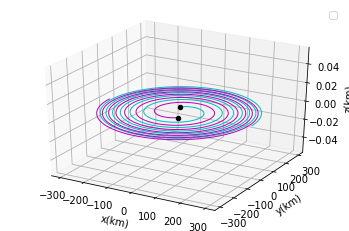

In [8]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rPN[0][0], rPN[0][1], rPN[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(rPN[1][0], rPN[1][1], rPN[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(rPN[0][0][-1], rPN[0][1][-1], rPN[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(rPN[1][0][-1], rPN[1][1][-1], rPN[1][2][-1], 'o', c='black') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(km)')
ax.set_ylabel('y(km)')
ax.set_zlabel('z(km)')


#plt.savefig('PNorbitaldecay.png', format='png', dpi=200)#, dpi=200
#plt.savefig('PNorbitaldecay.eps', box_inches='tight', format='eps')#,

plt.show()

with v2 jerk and dt = 0.1 at 30rs

In [173]:
print(timePN[-1])
print(timetomerge)
print(timePN[-1]*time_U)
print(timetomerge*time_U)
print(timePN[-1]*time_U/(timetomerge*time_U))

806292.0
896703.4096050006
2.2136657324955493
2.461889253588663
0.8991735632578591


with v2 jerk and dt = 0.01 at 20rs

In [ ]:
print(timePN[-1])
print(timetomerge)
print(timePN[-1]*time_U)
print(timetomerge*time_U)
print(timePN[-1]*time_U/(timetomerge*time_U))

with v2 jerk and dt = 1 at 20rs

In [171]:
print(timePN[-1])
print(timetomerge)
print(timePN[-1]*time_U)
print(timetomerge*time_U)
print(timePN[-1]*time_U/(timetomerge*time_U))

806292.0
896703.4096050006
2.2136657324955493
2.461889253588663
0.8991735632578591


with v2 jerk and dt = 0.1 at 20rs

In [167]:
print(timePN[-1])
print(timetomerge)
print(timePN[-1]*time_U)
print(timetomerge*time_U)
print(timePN[-1]*time_U/(timetomerge*time_U))

897429.099862857
896703.4096050006
2.463881628133149
2.461889253588663
1.000809286827822


In [168]:
print(np.linalg.norm(rPN[0].T[-1] - rPN[1].T[-1]))
bh.radisch*2

118.1036628113464


In [157]:
bh.radisch*2

118.08893290514095

with v2 jerk and dt = 0.1 at 15rs

In [7]:
print(timePN[-1])
print(timetomerge)
print(timePN[-1]*time_U)
print(timetomerge*time_U)
print(timePN[-1]*time_U/(timetomerge*time_U))

284426.5000055828
283722.5631953322
0.7808897973389342
0.7789571466432879
1.0024810744775556


In [8]:
print(np.linalg.norm(rPN[0].T[-1] - rPN[1].T[-1]))
bh.radisch*2

118.10553359824009


118.08893290514095

In [11]:
print(timePN[1])

0.1


with v2 jerk and dt = 0.1 at 10rs

In [140]:
print(timePN[-1])
print(timetomerge)
print(timePN[-1]*time_U)
print(timetomerge*time_U)
print(timePN[-1]*time_U/(timetomerge*time_U))

56704.39999945534
56043.96310031254
0.15568130052203782
0.15386807834929145
1.011784264755879


with v2 jerk and dt = 0.1 at 7rs

In [134]:
print(timePN[-1])
print(timetomerge)
print(timePN[-1]*time_U)
print(timetomerge*time_U)
print(timePN[-1]*time_U/(timetomerge*time_U))

14062.700000033628
13456.155540385038
0.03860898669023084
0.03694372561166487
1.0450756130031502


with v2 jerk and dt = 0.01 at 7rs

In [15]:
print(timePN[-1])
print(timetomerge)
print(timePN[-1]*time_U)
print(timetomerge*time_U)
print(timePN[-1]*time_U/(timetomerge*time_U))

14062.790000260538
13456.155540385038
0.03860923378485441
0.03694372561166487
1.0450823014088124


with v1 jerk and dt = 0.1 at 15rs

In [ ]:
print(timePN[-1])
print(timetomerge)

In [127]:
print(timePN[-1]*time_U)
print(timetomerge*time_U)

0.7189106600870864
0.7789571466432879


In [130]:
print(timePN[-1]*time_U/(timetomerge*time_U))
print(timetomerge*time_U/(timetomerge*time_U))

0.9229142619527196
1.0


 with v2 jerk and dt = 0.1 at 15rs

In [116]:
print(timePN[-1])
print(timetomerge)

261851.60001075387
283722.5631953322


No handles with labels found to put in legend.


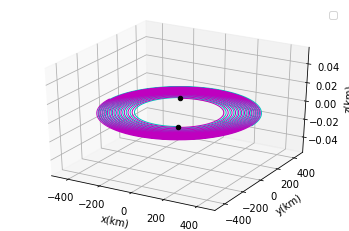

In [129]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rPN[0][0], rPN[0][1], rPN[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(rPN[1][0], rPN[1][1], rPN[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(rPN[0][0][-1], rPN[0][1][-1], rPN[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(rPN[1][0][-1], rPN[1][1][-1], rPN[1][2][-1], 'o', c='black') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(km)')
ax.set_ylabel('y(km)')
ax.set_zlabel('z(km)')


#plt.savefig('PNorbitaldecay.png', format='png', dpi=200)#, dpi=200
#plt.savefig('PNorbitaldecay.eps', box_inches='tight', format='eps')#,

plt.show()

In [58]:
print(np.linalg.norm(rPN[0].T[-1] - rPN[1].T[-1]))
print(timetomerge)
print(timePN[-1])
print(timePN[-1]/timetomerge)

118.0893179050539
56043.96310031254
56704.4800025651
1.0117856922621675


Gravitational wave extraction

In [59]:
rrelPN = rPN[0] - rPN[1]
vrelPN = vPN[0] - vPN[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dPN = np.zeros(len(rrelPN .T)) 

for i in range(len(rrelPN.T)):
    dPN[i] = np.linalg.norm(rrelPN.T[i])
    
#Obtain the relative velocity
vnrelPN = np.zeros(len(vrelPN.T))

for i in range(len(rrelPN.T)):
    vnrelPN[i] = np.linalg.norm(vrelPN.T[i])

In [60]:
vnrelPNkm = vnrelPN/kmsec_U*1000/c_SI
timePNsec = timePN*time_U

In [62]:
#Frequency
wsPN = np.zeros([len(dPN)])

for i in range(len(dPN)):
    wsPN[i] = ((bh.mass+bh.mass)/dPN[i]**3)**(1./2) 
    

In [63]:
hplusPN = np.zeros([len(dPN)]) #Could use Nsteps
#hcrossnsbh = np.zeros([len(dsimnsbh)])
#ro = 1.23*10**(22)#in km. LIGO's first detection, generated by two black holes some 1.3 billion light years away.
ro = 1.23*10**(21)

iangle = np.pi/2# i = pi/2 -> hx vanishes, i = 0 -> h+ and h- have the same amplitude

mu = (bh.mass*bh.mass)/(bh.mass+bh.mass)

for i in range(len(dPN)):
    hplusPN[i] = (1./ro)*(4*mu*(wsPN[i]**2)*(dPN[i]**2)/c_CU**4)*((1+np.cos(iangle)**2)/2)*np.cos(2*wsPN[i]*timePN[i])
    #hcross[i] = (1./ro)*(4*mu*(ws[i]**2)*(dsim[i]**2)/c_CU**4)*np.cos(iangle)*np.sin(2*ws[i]*timesimtp[i])

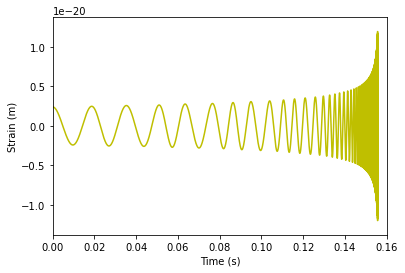

In [78]:
plt.plot(timePNsec, hplusPN, 'y-')
plt.axis([min(timePNsec), 1.03*max(timePNsec), 1.15*min(hplusPN), 1.15*max(hplusPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gwbhbh-PN-20M.eps', box_inches='tight')
plt.show()

#### Black Hole - Neutron Star Binary 

In [135]:
#Define ns
ns = md.Particle("NS",1.2,8.89,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius
#Define bh
bh3 = md.Particle("BH",5,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius

#Define binary
bh3nscol = md.Binary(bh3, ns, ns.radi*7, 0) ##primary, secondary, orbital distance (Rsun), eccentricity

print(bh3nscol.orbd)
print(bh3nscol.tideeffsec)

print(ns.radi)
print(bh3nscol.tidalrsec)


62.230000000000004
0.0005592401975367406
8.89
14.305334381906748


In [109]:
#Have implemented it, need to check it
timetomergebhns =  (5/256)*(bh3nscol.orbd**4)*(c_CU**5)*(1./(bh3.mass*ns.mass*(bh3.mass+ns.mass)))

print(timetomergebhns/bh3nscol.periodct)

accu = 0.01 #0.0001 Set accuracy parameter
tlbhns = 9*bh3nscol.periodct #Time of the simulation in [code units]
timelimitbhns = tlbhns #
dtbhns = 0.01 #Guess a timestep
Nstepsbhns = int(tlbhns/dtbhns)#Number of timesteps with the guessed timestep 

339.43954549817687


In [110]:
rPNbhns,vPNbhns,timePNbhns, dtpPNbhns = Hermite4thPNdt(bh3,ns, bh3nscol, Nstepsbhns, dtbhns)

In [111]:
print(min(dtpPNbhns[1:]))
print(max(dtpPNbhns))

0.0124068793714619
0.06891874577855127


In [112]:
print(timePNbhns[-1]/timetomergebhns)

0.007091207210419752


No handles with labels found to put in legend.


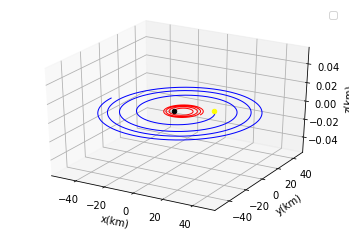

In [113]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rPNbhns[0][0], rPNbhns[0][1], rPNbhns[0][2], 'r', linewidth=1)# Plot the BH orbit
ax.plot(rPNbhns[1][0], rPNbhns[1][1], rPNbhns[1][2], 'b', linewidth=1)# Plot the star orbit
ax.scatter3D(rPNbhns[0][0][-1], rPNbhns[0][1][-1], rPNbhns[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(rPNbhns[1][0][-1], rPNbhns[1][1][-1], rPNbhns[1][2][-1], '0', c='yellow') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(km)')
ax.set_ylabel('y(km)')
ax.set_zlabel('z(km)')


#plt.savefig('PNorbitaldecay.png', format='png', dpi=200)#, dpi=200
#plt.savefig('PNorbitaldecay.eps', format='eps')#,

plt.show()

In [114]:
print(np.linalg.norm(rPNbhns[0].T[-1] - rPNbhns[1].T[-1]))


23.65213271528696


In [115]:
bh3nscol.tidalrsec

14.305334381906748

In [32]:
cmeasure = (aPNc[0][0][1:]*(c_CU**5)/(ac[0][0][1:] - aNc[0][0][1:]))**(1./5)

In [34]:
max(cmeasure)/c_CU
min(cmeasure)/c_CU

0.9999999999994251

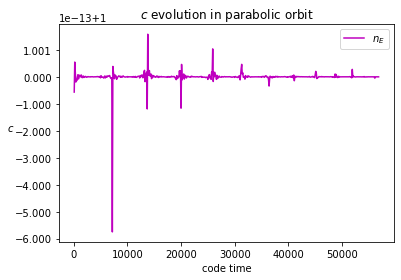

In [40]:
plt.plot(timePN[1:], cmeasurenorm, 'm-', label = r'$n_{E}$', alpha = 1)
#plt.plot(timearrayN.T[0][2:], n_ey[1:], 'b-', label = r'$n_{Ey}$', alpha = 0.5)
#plt.plot(timearrayT[1:], posydif, 'b-', label = r'$\Delta y$', alpha = 0.8)

#plt.plot(timeave, dynstave.T[1], 'b-', label = r'$star$', alpha = 0.8)
#plt.plot(time[1:], n_e.T[2], 'g-', label = r'$n_{ez}$', alpha = 0.8)
#plt.xlim(0,30)
#plt.ylim(13917.5,13917.8)
plt.xlabel('code time')
plt.ylabel(r'$c$',rotation=0)

plt.title(r'$c$ evolution in parabolic orbit')
plt.legend()
#plt.savefig('time-vs-ne-parabolicrp3rt.eps', bbox_inches='tight')#, dpi=300

plt.show()

dt = 0.01

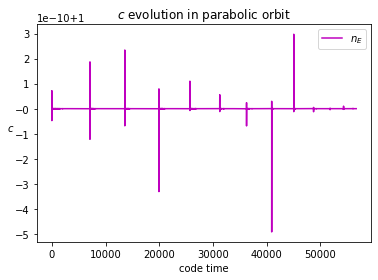

In [29]:
plt.plot(timePN[1:], cmeasurenorm, 'm-', label = r'$n_{E}$', alpha = 1)
#plt.plot(timearrayN.T[0][2:], n_ey[1:], 'b-', label = r'$n_{Ey}$', alpha = 0.5)
#plt.plot(timearrayT[1:], posydif, 'b-', label = r'$\Delta y$', alpha = 0.8)

#plt.plot(timeave, dynstave.T[1], 'b-', label = r'$star$', alpha = 0.8)
#plt.plot(time[1:], n_e.T[2], 'g-', label = r'$n_{ez}$', alpha = 0.8)
#plt.xlim(0,30)
#plt.ylim(13917.5,13917.8)
plt.xlabel('code time')
plt.ylabel(r'$c$',rotation=0)

plt.title(r'$c$ evolution in parabolic orbit')
plt.legend()
#plt.savefig('time-vs-ne-parabolicrp3rt.eps', bbox_inches='tight')#, dpi=300

plt.show()

In [39]:
cmeasurenorm = cmeasure/c_CU 
print(min(cmeasurenorm))
print(np.where(cmeasurenorm == min(cmeasurenorm)))


0.9999999999994251
(array([71]),)


In [24]:
aratio = np.zeros_like(aNc[1].T)
for i in range(len(aNc[1].T)-1):
    aratio[i+1][0] = (ac[1].T[i+1][0])/(aNc[1].T[i+1][0])
    aratio[i+1][1] = (ac[1].T[i+1][1])/(aNc[1].T[i+1][1])
    
    
#define relative position
relposTc = rPN[1].T - rPN[0].T 
#define relative velocity
relvelTc = vPN[1].T - vPN[0].T

normrelposTc = np.zeros([len(relposTc), 1]) 
normrelvelTc = np.zeros([len(relvelTc), 1]) 
rvdot =  np.zeros([len(relposTc), 1]) 

for i in range(len(normrelposTc)):
    normrelposTc[i] = np.sqrt(relposTc[i][0]**2 + relposTc[i][1]**2 + relposTc[i][2]**2)
    normrelvelTc[i] = np.sqrt(relvelTc[i][0]**2 + relvelTc[i][1]**2 + relvelTc[i][2]**2)
    rvdot[i] = np.dot(relposTc[i],relvelTc[i])
    
print(len(normrelposTc.T[0]))
print(min(normrelposTc))
print(max(normrelposTc))

567045
[118.10631389]
[590.44466453]


In [25]:
rsub = normrelposTc.T[0]**5
vsub = normrelvelTc.T[0]**5
aPNformulax = (4/5)*(1/rsub)*((2*bh.mass/rsub - 8*bh.mass/rsub - vsub**2)*relvelTc.T[0] + rvdot.T[0]*( (52*bh.mass/(3*rsub**3)) - (6*bh.mass/rsub**3) + (3*vsub**2/rsub**2))*relposTc.T[0])

In [26]:
c5 = aPNformulax/(aratio.T[0] - 1) 

In [27]:
print(c5)

[ 0.00000000e+00 -1.63661874e-18  3.27324342e-18 ... -7.35768598e-14
 -7.37023793e-14 -7.38280584e-14]


In [28]:
#print(cmeasurenorm[71011+4])

dt = 0.05

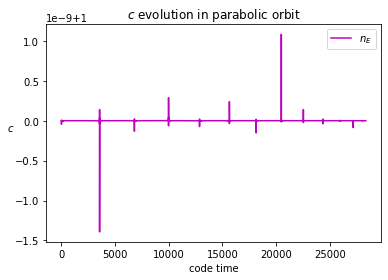

In [29]:
plt.plot(timePN[1:], cmeasurenorm, 'm-', label = r'$n_{E}$', alpha = 1)
#plt.plot(timearrayN.T[0][2:], n_ey[1:], 'b-', label = r'$n_{Ey}$', alpha = 0.5)
#plt.plot(timearrayT[1:], posydif, 'b-', label = r'$\Delta y$', alpha = 0.8)

#plt.plot(timeave, dynstave.T[1], 'b-', label = r'$star$', alpha = 0.8)
#plt.plot(time[1:], n_e.T[2], 'g-', label = r'$n_{ez}$', alpha = 0.8)
#plt.xlim(0,30)
#plt.ylim(13917.5,13917.8)
plt.xlabel('code time')
plt.ylabel(r'$c$',rotation=0)

plt.title(r'$c$ evolution in parabolic orbit')
plt.legend()
#plt.savefig('time-vs-ne-parabolicrp3rt.eps', bbox_inches='tight')#, dpi=300

plt.show()